# Part 2/2 operations on previously prepared data (reports and visualization)

*This project is made for Piotr Mitkowski portfolio to show some usage of data analyst python libraries to create, transform, and visual represent alphanumerical data*
###### Imagine there a company that sells consoles, games and accesories via Internet in Central Easter Europe (Mostly in Poland, excluding Russia..). As Polish company all sales is calculated into "PLN" currency, Foreign sales is booked always in EUR. Data are randomly generated but distribution is set with some indicators eg. to make Polish sales highest compared with other countries
*Bullet Points of part 2/2- used skills*
* *1.working with pandas loading data, pivots, aggregation, filtering, merging dataframes
* *2. visualization with matplotlib/seaborn
* *3. visalization with plotly -> .html files (dashboards)
* *4. creating custom reports in excel
* *5. all of that packed into methods

# imports

In [1]:
import pandas as pd
import numpy as np
#pd.options.mode.chained_assignment = None  # default='warn'

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly
import plotly.graph_objects as go

import glob
from os.path import join

#progress bar 
from tqdm.auto import tqdm

#rquest to update NBP fx rates viaAPI
import requests

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

### date setting 

In [2]:
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")
current_year = now.year
current_month = now.month

### Paths

In [3]:
CWD = Path.cwd()
DATA = CWD / "DATA"
OUTPUT = CWD/ "OUTPUT_"
OUTPUT.mkdir(parents=True, exist_ok=True)
CHARTS = OUTPUT/"CHARTS"
CHARTS.mkdir(parents=True, exist_ok=True)
DASHBOARDS = OUTPUT/"DASHBOARDS"
DASHBOARDS.mkdir(parents=True, exist_ok=True)
EXCEL = OUTPUT/"EXCEL"
EXCEL.mkdir(parents=True, exist_ok=True)


### my helpfer methods --> saved as external library

In [4]:
#import above
from DATA.helper_methods import month_number_to_name

### Importing .pickle data previously prepared

In [5]:
#check for all pickle files
pickle_file_dict = dict(enumerate(glob.glob(join(OUTPUT, "*.pickle"))))
pickle_file_dict

{0: 'C:\\Users\\Piotr\\Jupyter_WS\\_0_PORTFOLIO_PROJECTS\\_1 DataAnalyst\\OUTPUT_\\SALES_DATA 2023-02-16.pickle'}

In [6]:
#workspace dataframe df_ws
#Selecting data
df_ws = pd.read_pickle(pickle_file_dict[0])

In [7]:
#summary
print(f"Imported Data Details:\nSize: {round(df_ws.memory_usage().sum()/1024/1024,2)} MB\nNumber of columns: {len(df_ws.columns)} * Number of rows: {len(df_ws.index)}\nNumber of unique datatypes in this data : {df_ws.dtypes.nunique()}")

Imported Data Details:
Size: 10.39 MB
Number of columns: 28 * Number of rows: 131224
Number of unique datatypes in this data : 17


## overview pivot for company revenue by country, by year

In [8]:
df_revenue_by_year_country =pd.pivot_table(df_ws,values=['total_value_in_pln'], index=['sales_country_name'],columns=["year"],aggfunc="sum",margins=True,fill_value = 0, margins_name="Total_Revenue_M_PLN")['total_value_in_pln']/1000/1000

In [9]:
df_margin_by_year_country=pd.pivot_table(df_ws,values=['ttl_margin_pln'], index=['sales_country_name'],columns=["year"],aggfunc="sum",margins=True,fill_value = 0, margins_name="Total_Margin_M_PLN")['ttl_margin_pln']/1000/1000

### look at margins

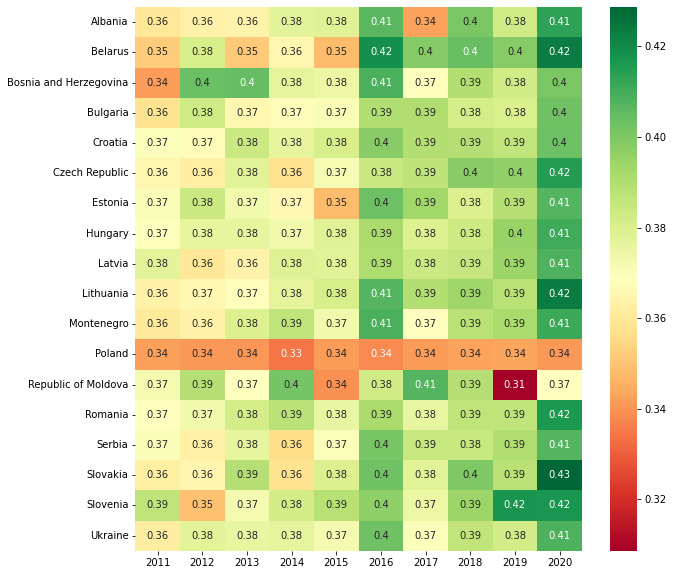

In [10]:
df_percentage_margin_by_year_country = df_margin_by_year_country[df_margin_by_year_country.columns[:-1]].loc[df_margin_by_year_country.index[:-1]]/df_revenue_by_year_country[df_revenue_by_year_country.columns[:-1]].loc[df_revenue_by_year_country.index[:-1]]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_percentage_margin_by_year_country, cmap="RdYlGn",annot=True)
ax.set(xlabel="",ylabel="")
plt.savefig(join(CHARTS,f'margin_heatmap_{current_date}.png'))

## Let's create random budgets values by year,product category and month for each country for the purspose of visual presentation pursposes

In [11]:
df_total_plus_budgets =pd.pivot_table(df_ws,values=['total_value_in_pln','ttl_margin_pln'], index=['year','month','product_category','sales_region_name','sales_country_name'],aggfunc="sum")
#we need random values in same shape as pivot
BG_SIZE = df_total_plus_budgets.shape
#lets arrange random budgets slightly lover than actual this can be modified the way aroung using e.g. -15,55 instead of -55,15 
bg_random = np.random.randint(-55,15, BG_SIZE)/100+1
bg_random.shape
df_bgts = round(df_total_plus_budgets * bg_random,-2) ### rounded to houndreds of pln
df_bgts.columns=  ['ttl_bg_rev_in_pln', 'ttl_bg_margin_in_pln']
#join budgets and actuals
df_total_plus_budgets = df_total_plus_budgets.join(df_bgts)
df_total_plus_budgets.reset_index(inplace=True)
df_total_plus_budgets.head(3)

,year,month,product_category,sales_region_name,sales_country_name,total_value_in_pln,ttl_margin_pln,ttl_bg_rev_in_pln,ttl_bg_margin_in_pln
0,2011,1,Accessories,Balkans,Albania,70.370003,15.810000,100.0,0.0
1,2011,1,Accessories,Balkans,Belarus,0.000000,0.000000,0.0,0.0
2,2011,1,Accessories,Balkans,Bosnia and Herzegovina,646.580017,275.179993,600.0,300.0


## plot_act_vs_budget - method

In [12]:
def plot_act_vs_budget(df: pd.DataFrame,
                       df_filter_columns: list,
                       year:int,
                       month: int = None,
                       product_category:str= None,
                       country:str = None,
                       region:str = None):
    """
    method to plot a set of charts (2x2) to present revenue and margin vs plan by month, and in aggregate form
    filter_columns_list must be str list of columns for filter in order : year, month, product_category, country, region for this to work
    """
    scenario = "YTD" if month!= None else "FY"
    titles_rev = f"Revenue vs Budget {month_number_to_name(month)[:3]} {scenario} {year}\n" if month!= None else f"Revenue vs Budget {scenario} {year}\n"
    filename= "act_vs_bg "
    
    #filtry:
    if scenario =="YTD":
        df = df[df[df_filter_columns[1]] <= month]
    
    if year != None:
        df = df[df[df_filter_columns[0]] == year]
        
    if product_category != None:
        df = df[df[df_filter_columns[2]] == product_category]
        titles_rev += f"{df_filter_columns[2]}: {product_category}\n"
        filename+= f"{df_filter_columns[2]}-{product_category} "
        
    if country != None:
        df = df[df[df_filter_columns[4]] == country]
        titles_rev += f"{df_filter_columns[4]}: {country}\n"
        filename+= f"{df_filter_columns[4]}-{country} "
        
    if region != None:
        df = df[df[df_filter_columns[3]] == region]
        titles_rev += f"{df_filter_columns[3]}: {region}\n"
        filename+= f"{df_filter_columns[3]}-{region} "
    
    #title for margin charts
    titles_mar = titles_rev.replace("Revenue","Margin")
        
    #removing year column before summing then aggregate data by month
    groups = df.drop(df_filter_columns[0], axis=1).groupby(by=["month"])
    df_output = groups.agg("sum")/1000/1000
    #new column names
    df_output.columns = ["Actual_Revenue_PLN","Actual_Margin_PLN","Budget_Revenue_PLN","Budget_Margin_PLN"]
    
    #additional data needed to chards
    max_rev = [df_output['Actual_Revenue_PLN'].argmax()+1, df_output['Actual_Revenue_PLN'].max()]
    
    #YTD/YE
    ttl_rev_act,ttl_mar_act,ttl_rev_bgt,ttl_mar_bgt = df_output[df_output.columns[0]].sum(),df_output[df_output.columns[1]].sum(),df_output[df_output.columns[2]].sum(),df_output[df_output.columns[3]].sum()
    rev_x1, rev_x2, mar_x1, mar_x2 = 0,0,0,0
    rev_x1_clr,mar_x1_clr, rev_x2_clr,mar_x2_clr= "y","y","g","g"
    label_x1_rev, label_x1_mar,label_x2_rev, label_x2_mar = "Budget","Budget","",""
    
    pct_rev, pct_mar = ttl_rev_act/ttl_rev_bgt *100, ttl_mar_act/ttl_mar_bgt*100
    
    #achiev pie charts
    if ttl_rev_act <= ttl_rev_bgt:
        rev_x1, rev_x2 = ttl_rev_act, ttl_rev_bgt-ttl_rev_act
        rev_x1_clr, rev_x2_clr = "b", "r"
        label_x2_rev = f"- {rev_x2:.2f}mPLN missing to BG"
        label_x1_rev = "BG Achieved"
    else:
        rev_x1, rev_x2 = ttl_rev_bgt, ttl_rev_act-ttl_rev_bgt
        label_x2_rev = f"+ {rev_x2:.2f}mPLN above BG"
        
    if ttl_mar_act <= ttl_mar_bgt:
        mar_x1, mar_x2 = ttl_mar_act, ttl_mar_bgt-ttl_mar_act
        mar_x1_clr, mar_x2_clr = "b", "r"
        label_x2_mar = f"- {mar_x2:.2f}mPLN missing to BG"
        label_x1_mar = "BG Achieved"
    else:
        mar_x1, mar_x2 = ttl_mar_bgt, ttl_mar_act-ttl_mar_bgt
        label_x2_rev = f"+ {mar_x2:.2f}mPLN above BG"
    
    #setup a plot
    plt.figure(figsize=(15,15))
    #subplots
    plt.subplot(2,2,1)
    plt.plot(df_output.index ,df_output['Actual_Revenue_PLN'], label="actual", c="red", marker=".")
    plt.bar(df_output.index ,df_output['Budget_Revenue_PLN'], label="budget", color="y")
    plt.title(titles_rev)
    plt.xlabel("Months")
    plt.ylabel("Revenue mPLN")
    plt.xticks(np.linspace(1,len(df_output.index),len(df_output.index)))
    plt.legend()
    plt.annotate(f'year max:{max_rev[1]:.2f} mPLN', xy=(max_rev[0], max_rev[1]), xytext=(round(len(df_output.index)/2,0),max_rev[1]),
             arrowprops=dict(facecolor='black', shrink=0.1),
             )
    
    #subplots
    plt.subplot(2,2,2)
    plt.plot(df_output.index ,df_output['Actual_Margin_PLN'], label="margin", c="b",marker="*")
    plt.bar(df_output.index ,df_output['Budget_Margin_PLN'], label="budget", color="y")
    plt.title(titles_mar)
    plt.xlabel("Months")
    plt.ylabel("Margin mPLN")
    plt.xticks(np.linspace(1,len(df_output.index),len(df_output.index)))
    plt.legend()
    
    #pie REV
    plt.subplot(2,2,3)
    plt.pie([rev_x1,rev_x2], colors=[rev_x1_clr,rev_x2_clr], labels=[label_x1_rev,label_x2_rev],startangle=90)
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    fig = plt.gcf()
    # Adding Circle in Pie chart
    fig.gca().add_artist(centre_circle)
    plt.text(0,0,f"{pct_rev:.1f} %", fontsize=42,c=rev_x2_clr, horizontalalignment='center',verticalalignment='center')
    plt.title(f"{scenario} {year} Revenue BG Achievment")
    
    #pie MAR
    plt.subplot(2,2,4)
    plt.pie([mar_x1,mar_x2], colors=[mar_x1_clr,mar_x2_clr], labels=[label_x1_mar,label_x2_mar],startangle=90)
    centre_circle = plt.Circle((0, 0), 0.6, fc='white')
    fig = plt.gcf()
    # Adding Circle in Pie chart
    fig.gca().add_artist(centre_circle)
    plt.text(0,0,f"{pct_mar:.1f} %", fontsize=42,c=mar_x2_clr, horizontalalignment='center',verticalalignment='center')
    plt.title(f"{scenario} {year} Margin BG Achievment")
    
    #save to .png in OUTPUT/ charts
    plt.savefig(join(CHARTS, f"{filename}_{current_date}.png"))
    

## gross_ret_split method

In [13]:
def get_gross_ret_split(df: pd.DataFrame,
                        month: int = None,
                        year: int = None,
                        region: str = None,
                        category: str = None,
                        country: str = None,
                        product: str = None,
                        scenario: str = None,
                       ):
    """
    this is helper method to quickly check sales by transaction_type : Sales or returns. It works only on raw data data directly loaded from pickle
    """
    #filters based on input
    if scenario is None and month is None:
        scenario ="FY"
    if scenario =="YTD":
        if month is None:
            return "you need to pass month along with YTD scenario"
        else:
            df = df[df["month"] <= month]
    elif scenario == "MTD":
        if month is None:
            return "you need to pass month along with MTD scenario"
        else:
            df = df[df["month"] == month]        
    elif scenario != "FY":
        return "wrong scenario choice"
    
    if year != None:
        df = df[df["year"] == year]
    
    if country != None:
        df = df[df["sales_country_name"] == country]
        
    if region != None:
        df = df[df["sales_region_name"] == region]
        
    if product != None:
        df = df[df["product_name"] == product]
        
    if category != None:
        df = df[df["product_category"] == category]
    
    gross = round(df[df['transaction_type']=="gross"]['total_value_in_pln'].sum()/1000/1000,5)
    returns = round(df[df['transaction_type']=="returns"]['total_value_in_pln'].sum()/1000/1000,5)
    pct_ret = -returns/gross*100 if gross!=0 else 0 
    net = gross+returns
    
    return gross, returns,net, pct_ret, df

## Top_n_titles -method


In [14]:
def top_n_things(df: pd.DataFrame,
                column_with_thing: str,
                column_with_value: str,
                top_n_number: int = 5,
                scenario: str = "FY",
                year: int = None,
                month:int = None,
                region: str = None,
                country: str = None,
                aggtype: str = "sum"):
    """
    Returns top n things (can be product, can be other field) by highest selected value_field, it can be volume, revenue, margin. You can specify country, period,region or even agg_func type (sum/count/etc.)
    """
    #filters based on input
    #month
    if scenario =="YTD":
        if month is None:
            return "you need to pass month along with YTD scenario"
        else:
            df = df[df["month"] <= month]
    elif scenario == "MTD":
        if month is None:
            return "you need to pass month along with MTD scenario"
        else:
            df = df[df["month"] == month]
    elif scenario != "FY":
        return "wrong scenario choice"
    
    if year != None:
        df = df[df["year"] == year]
    
    if country != None:
        df = df[df["sales_country_name"] == country]
        
    if region != None:
        df = df[df["sales_region_name"] == region]
        
    ### data agg (sum) by column with thing
    groups = df.groupby(by=column_with_thing)
    df_output = groups.agg({column_with_value: aggtype})
    df_output.sort_values(by=[column_with_value], inplace=True , ascending=False)
    df_output.columns = [f"{column_with_value}_{aggtype}"]
    return df_output.head(top_n_number)

### helper method - prepare_pie_inputs - to customize Pie charts in dashboard

In [15]:
def prepare_pie_inputs(df: pd.DataFrame,
                       column_1: str,
                       column_2: str):
    """
    helper method that sums two given columns (column1, column2) compares them and returns dictionary to format budget achiev piecharts in dashboard
    """
    
    ttl_column1, ttl_column2 = df[column_1].sum(),df[column_2].sum()
    x1, x2 = 0,0
    x1_inner, x2_inner= 0,1
    x1_color, x2_color, x1_inner_color, x2_inner_color = "forestgreen", "#111111","darkorange","darkblue"
    if ttl_column1 < ttl_column2:
        x1, x2 = 1 ,0
        x1_inner, x2_inner = ttl_column1, ttl_column2-ttl_column1
        x1_inner_color, x2_inner_color = "darkblue","darkorange"
        x1_color, x2_color =  "#111111","forestgreen"
    elif ttl_column1 >= ttl_column2:
        if ttl_column1/ttl_column1>=2:
            x1,x2 = 1,0
        else:
            x1= ttl_column1-ttl_column2
            x2 = ttl_column2-x1
    pct_achiev = ttl_column1/ttl_column2*100    
    return {"ttl_column1": ttl_column1,"ttl_column2": ttl_column2,"pct_achiev": pct_achiev, "x1":x1,"x2":x2, "x1_inner":x1_inner,"x2_inner":x2_inner, "x1_color":x1_color,"x2_color":x2_color, "x1_inner_color":x1_inner_color, "x2_inner_color":x2_inner_color}

# Using my custom methods to analize and visualize data
below please find cheat dictionaries to use methods correctly

In [16]:
dict_scenario= {0: "YTD",1:"FY",2:"MTD"}
dict_countries = dict(enumerate(df_ws['sales_country_name'].unique()))
dict_region = dict(enumerate(df_ws['sales_region_name'].unique()))
dict_category = dict(enumerate(df_ws['product_category'].unique()))
dict_aggtype = {0:"sum", 1:"mean", 2:"count"}
dict_data_column_names = dict(enumerate(df_ws.columns))
print(f"dict_scenario: {dict_scenario}")
print(f"dict_countries: {dict_countries}")
print(f"dict_region: {dict_region}")
print(f"dict_category: {dict_category}")
print(f"dict_aggtype: {dict_aggtype}")
print(f"dict_data_column_names: {dict_data_column_names}")

dict_scenario: {0: 'YTD', 1: 'FY', 2: 'MTD'}
dict_countries: {0: 'Romania', 1: 'Bulgaria', 2: 'Poland', 3: 'Montenegro', 4: 'Hungary', 5: 'Belarus', 6: 'Lithuania', 7: 'Ukraine', 8: 'Latvia', 9: 'Croatia', 10: 'Serbia', 11: 'Bosnia and Herzegovina', 12: 'Slovakia', 13: 'Czech Republic', 14: 'Albania', 15: 'Estonia', 16: 'Slovenia', 17: 'Republic of Moldova'}
dict_region: {0: 'Central Europe', 1: 'Balkans', 2: 'Poland', 3: 'Eastern Europe', 4: 'Baltics'}
dict_category: {0: 'Accessories', 1: 'Game', 2: 'Console'}
dict_aggtype: {0: 'sum', 1: 'mean', 2: 'count'}
dict_data_column_names: {0: 'sales_country_code', 1: 'sales_country_name', 2: 'sales_region_name', 3: 'product_ID', 4: 'product_name', 5: 'product_category', 6: 'volume', 7: 'transaction_type', 8: 'sales_currency', 9: 'year', 10: 'month', 11: 'date', 12: 'day', 13: 'city', 14: 'user', 15: 'email', 16: 'discount_code', 17: 'discount_rate', 18: 'discount_description', 19: '_hc_inflation_impact', 20: 'sales_price_in_currency', 21: 'di

In [17]:
#columns selection as filters to use in method plot_act_vs_budget
df_filter_columns = df_total_plus_budgets.columns[:5]
#for other data set you may declare it manually as list, eg df_filter_columns = ["column1","column2"..."column5"]


### plotting September YTD 2019 act vs bg (in Poland, Game category only)

C:\Users\Piotr\AppData\Local\Temp/ipykernel_28640/1013004921.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_output = groups.agg("sum")/1000/1000


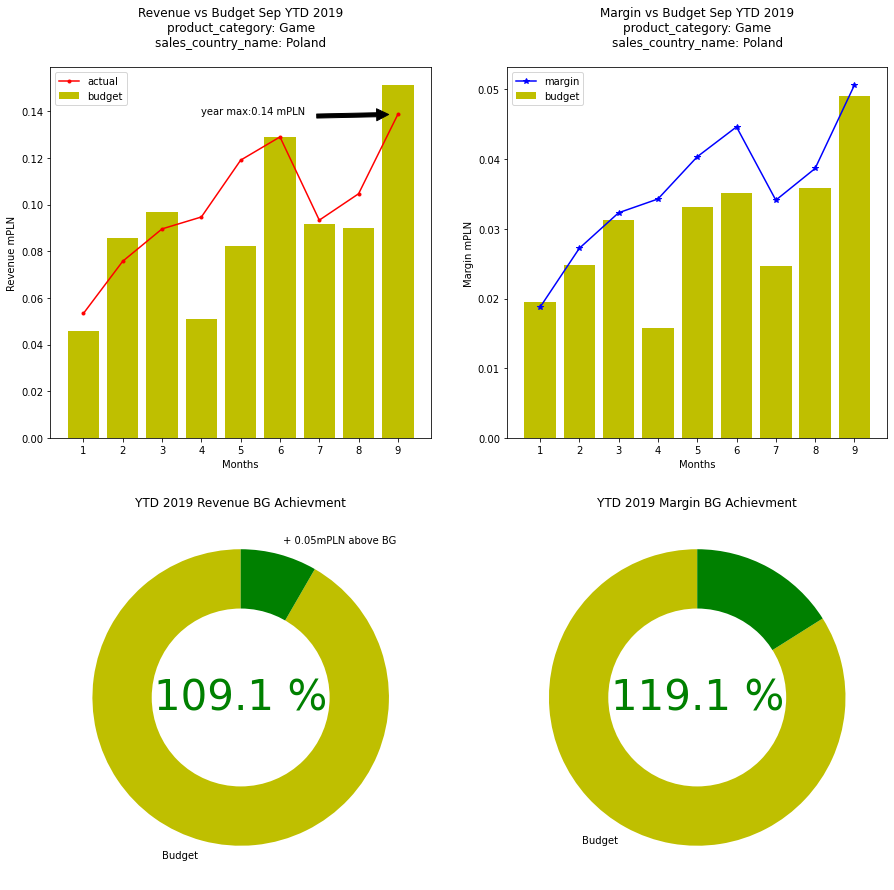

In [18]:
plot_act_vs_budget(df=df_total_plus_budgets,
                   df_filter_columns=df_filter_columns,
                   year=2019,
                   month=9,
                   product_category="Game",
                  country="Poland")

In [19]:
### plotting 2018 Full year act_vs_bg for all categories in Balkans region

C:\Users\Piotr\AppData\Local\Temp/ipykernel_28640/1013004921.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_output = groups.agg("sum")/1000/1000


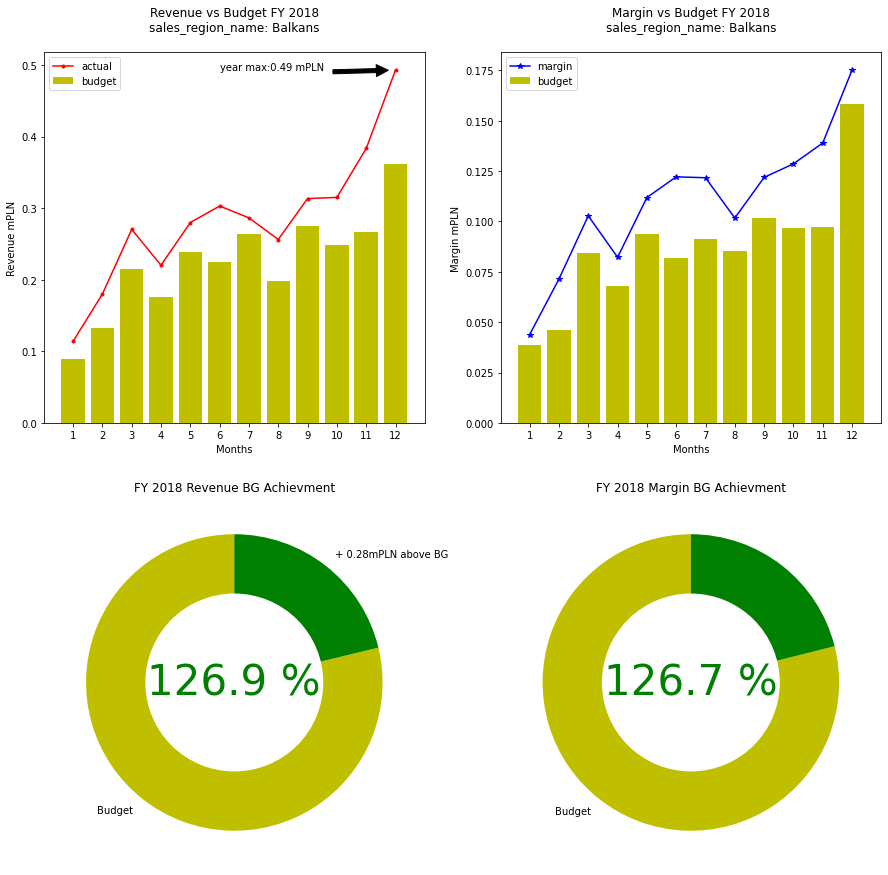

In [20]:
plot_act_vs_budget(df=df_total_plus_budgets,
                   df_filter_columns=df_filter_columns,
                   year=2018,
                  region="Balkans")

## Let's check what was top 5 sold Products (volume), in 2015 (full year), in Balkans

In [21]:
top_n_things(df_ws,
             column_with_thing ="product_name",
             column_with_value="volume",
             top_n_number=5,
             year=2015,
             scenario="FY",
             region=dict_region[3],
             aggtype="sum")

,volume_sum
product_name,
Super Tropper [Xbox],169
Assassin's Creed [PS5],128
Headphones 2.0 [PS4/PS5],117
Fifa [Xbox],105
Internet Cable [15m],93


## Now, how about top 3 Used Discounts type in whole CEE in Full year 2018

In [22]:
top_n_things(df_ws,
             column_with_thing ="discount_description",
             column_with_value="volume",
             top_n_number=3,
             year=2015,
             scenario="FY",
             aggtype="count")

,volume_count
discount_description,
No Discount,8165
10% in magazines and web,1623
5% incluancer partnerships,1623


## Up next, top 10 Profitable Products in Baltic Region in whole period of 10 year 
/1000/1000 to have it milions

In [23]:
top_n_things(df_ws,
             column_with_thing ="product_name",
             column_with_value="ttl_margin_pln",
             top_n_number=10,
             aggtype="sum")/1000/1000

,ttl_margin_pln_sum
product_name,
Racing Wheel [Xbox],4.239236
Racing Wheel [PS5],4.065095
Super Tropper [Xbox],3.491353
Playstation 5 Blue-Ray,3.487840
Xbox S,1.939353
Assassin's Creed [PS5],1.906931
Headphones 2.0 [PS4/PS5],1.773557
Playstation 5 Digital,1.628238
Mario [PS4/PS5],1.014205


## gross / returns/ net split for Balkans in 2015

In [24]:
balkans_2015_gross,balkans_2015_ret,balkans_2015_net= get_gross_ret_split(df=df_ws,
                    year=2015,
                    region="Balkans")[:3]
#check
balkans_2015_gross + balkans_2015_ret ==balkans_2015_net

True

# DashBoards per region

In [25]:
def create_region_report(df_act_bg: pd.DataFrame,
                         df_ws: pd.DataFrame,
                         year:int,
                         month: int,
                         region:str,
                        report_date:str=current_date):
    """
    This creates .html dashboard in plotly for given year, month and most important region
    """
    #filters for given parameters
    conditions_ytd = (df_act_bg["month"] <= month) & (df_act_bg["year"] == year) & (df_act_bg["sales_region_name"] == region)
    df_ytd = df_act_bg[conditions_ytd]
    df_mtd =df_ytd[df_ytd["month"] ==month]
    
    #additional variables
    pie_setting_mtd = prepare_pie_inputs(df=df_mtd,column_1="total_value_in_pln",column_2="ttl_bg_rev_in_pln")
    pie_setting_ytd = prepare_pie_inputs(df=df_ytd,column_1="total_value_in_pln",column_2="ttl_bg_rev_in_pln")
    
    ret_gross_YTD = get_gross_ret_split(df_ws,scenario="YTD", month=month, year=year, region=region)
    
    ttl_margin_YTD = round(df_ytd['ttl_margin_pln'].sum()/1000/1000,5)
    ttl_net_sales_YTD = round(ret_gross_YTD[2],5)
    
    #data transform for sales by month
    df_by_month = round(df_ytd.groupby(["month","product_category"],observed=True).agg(act_rev_pln = ("total_value_in_pln","sum"),
                                                                bgt_rev_pln = ("ttl_bg_rev_in_pln","sum")).unstack()/1000/1000,3)
    #merging two levels of column names into one
    df_by_month.columns = ['_'.join(col) for col in df_by_month.columns]
    df_by_month['bgt_rev_ttl_pln'] = df_by_month[df_by_month.columns[3:]].sum(axis=1)
    df_by_month['act_rev_ttl_pln'] = df_by_month[df_by_month.columns[:3]].sum(axis=1)

    #label columns#label actual
    df_by_month['act_label'] = "<b>Accessories mPLN:</b>" + df_by_month['act_rev_pln_Accessories'].astype("str") + "<br><b>Consoles mPLN:</b>" + \
    df_by_month['act_rev_pln_Console'].astype("str") + "<br><b>Games mPLN:</b>" + df_by_month['act_rev_pln_Game'].astype("str")
    #label columns#label budget
    df_by_month['bgt_label'] = "<b>Accessories mPLN:</b>" + df_by_month['bgt_rev_pln_Accessories'].astype("str") + "<br><b>Consoles mPLN:</b>" + \
    df_by_month['bgt_rev_pln_Console'].astype("str") + "<br><b>Games mPLN:</b>" + df_by_month['bgt_rev_pln_Game'].astype("str")
    df_by_month['month_name'] = df_by_month.index
    df_by_month['month_name'] = df_by_month['month_name'].apply(month_number_to_name)
    
    #data transform for sales by country
    df_by_country = round(df_ytd.groupby(["sales_country_name","product_category"], observed=True).agg(act_rev_pln = ("total_value_in_pln","sum"),
                                                                bgt_rev_pln = ("ttl_bg_rev_in_pln","sum")).unstack()/1000/1000,3)
    df_by_country.columns = ['_'.join(col) for col in df_by_country.columns]
    df_by_country['bgt_rev_ttl_pln'] = df_by_country[df_by_country.columns[3:]].sum(axis=1)
    df_by_country['act_rev_ttl_pln'] = df_by_country[df_by_country.columns[:3]].sum(axis=1)
    #need to delete zero rows are categorical variable is in aggregation despine being filtered (country name)
    for i in df_by_country.index:
        if df_by_country.loc[i]['act_rev_ttl_pln'] ==0:
            df_by_country.drop(i,inplace=True)
    #label columns#label actual
    df_by_country['act_label'] = "<b>Accessories mPLN:</b>" + df_by_country['act_rev_pln_Accessories'].astype("str") + "<br><b>Consoles mPLN:</b>" + \
    df_by_country['act_rev_pln_Console'].astype("str") + "<br><b>Games mPLN:</b>" + df_by_country['act_rev_pln_Game'].astype("str")
    #label columns#label budget
    df_by_country['bgt_label'] = "<b>Accessories mPLN:</b>" + df_by_country['bgt_rev_pln_Accessories'].astype("str") + "<br><b>Consoles mPLN:</b>" + \
    df_by_country['bgt_rev_pln_Console'].astype("str") + "<br><b>Games mPLN:</b>" + df_by_country['bgt_rev_pln_Game'].astype("str")
    
    #top product
    top_five = top_n_things(df=df_ws,
             column_with_thing ="product_name",
             column_with_value="volume",
             top_n_number=5,
             month=month,
             year=year,
             scenario="YTD",
             aggtype="sum").reset_index()
    
    #initiate subplots
    fig= make_subplots(rows=3, cols=3,
                       column_widths=[0.3, 0.3, 0.4],                   
                       row_heights=[1., 1., 1.],
                       specs=[[{"type": "pie"},{"type": "pie"}, {"type": "bar", "rowspan":2}],
                              [{"type": "bar", "colspan":2}, None, None],
                              [{"type": "pie"},{"type": "pie"},{"type": "table"}]]
                      )

    fig.update_layout(title=f'Regional {region} {month_number_to_name(month)} YTD {year} Report | generated on: {report_date}',
                      font=dict(family="Times New Roman",
                                size=24,
                                color="#87CEFA"),
                      template="plotly_dark",
    )

    #pie chart MTD 1,1
    ## inner pie
    fig.add_trace(go.Pie(values=[pie_setting_mtd["x1_inner"],pie_setting_mtd["x2_inner"]],
                         showlegend=False,
                         textfont=dict(color=[pie_setting_mtd["x1_inner_color"],pie_setting_mtd["x2_inner_color"]]),
                         marker=dict(colors=[pie_setting_mtd["x1_inner_color"],pie_setting_mtd["x2_inner_color"]]),
                         hoverinfo='none',
                         hole=0.5, title=f"MTD:{pie_setting_mtd['pct_achiev']:.1f}%", titlefont={'size':34, 'color': 'yellow'},titleposition="middle center", 
                        ),
                  row = 1, col = 1
                 )
    #outer PIe
    if pie_setting_mtd['pct_achiev'] > 100:
        fig.add_trace(go.Pie(values=[pie_setting_mtd["x1"],pie_setting_mtd["x2"]],
                         showlegend=False,
                         textfont=dict(color=[pie_setting_mtd['x1_color'],pie_setting_mtd['x2_color']]),
                         marker=dict(colors=[pie_setting_mtd['x1_color'],pie_setting_mtd['x2_color']]),
                         hoverinfo='none',#
                         hole=0.8,
                        ),
                  row = 1, col = 1
                 )


    #pie chart YTD 1,2
    ## inner pie
    fig.add_trace(go.Pie(values=[pie_setting_ytd["x1_inner"],pie_setting_ytd["x2_inner"]],
                         showlegend=False,
                         textfont=dict(color=[pie_setting_ytd["x1_inner_color"],pie_setting_ytd["x2_inner_color"]]),
                         marker=dict(colors=[pie_setting_ytd["x1_inner_color"],pie_setting_ytd["x2_inner_color"]]),
                         hoverinfo='none',
                         hole=0.5,titleposition="middle center", 
                         title=f"YTD:{pie_setting_ytd['pct_achiev']:.1f}%", 
                         titlefont={'size':34, 'color': 'yellow'},
                        ),
                  row = 1, col = 2
                 )
    #outer PIe
    if pie_setting_ytd['pct_achiev'] > 100:
        fig.add_trace(go.Pie(values=[pie_setting_ytd["x1"],pie_setting_ytd["x2"]],
                             showlegend=False,
                             textfont=dict(color=[pie_setting_ytd['x1_color'],pie_setting_ytd['x2_color']]),
                             marker=dict(colors=[pie_setting_ytd['x1_color'],pie_setting_ytd['x2_color']]),
                             hoverinfo='none',
                             hole=0.8,
                            ),
                      row = 1, col = 2
                     )


    #pie chart Margin  3,1
    fig.add_trace(go.Pie(values=[ttl_margin_YTD,ttl_net_sales_YTD-ttl_margin_YTD],
                         showlegend=False,
                         name="margin",
                         hovertext=[f"<b>Margin mPLN: {ttl_margin_YTD:.2f}</b>",
                                    f"<b>Cos mPLN: {ttl_net_sales_YTD-ttl_margin_YTD:.3f}</b><br><b>net sales mPLN: {ret_gross_YTD[2]:.3f}</b><br><b>Gross sales mPLN: {ret_gross_YTD[0]:.3f}</b>"],
                         title=f"{month_number_to_name(month)} YTD Margin::",
                         labels=['Margin','COS'],
                         titleposition="bottom center",
                         textfont={'size':25},
                         marker=dict(colors=["green","lightskyblue"]),
                        ),
                  row = 3, col = 1
                 )

    #pie chart Returns YTD 3,2
    fig.add_trace(go.Pie(values=[ret_gross_YTD[2],-ret_gross_YTD[1]],
                         showlegend=False,
                         name="returns",
                         hovertext=[f"<b>Net Sales mPLN: {ret_gross_YTD[2]:.3f}</b><br><b>Gross Sales mPLN: {ret_gross_YTD[0]:.3f}</b>",
                                    f"<b>Returns mPLN: {-ret_gross_YTD[1]:.3f}</b>"],
                         title=f"{month_number_to_name(month)} YTD Returns:",
                         labels=['Net','Returns'],
                         titleposition="bottom center",
                         textfont={'size':25},
                         marker=dict(colors=["lightskyblue","darkorange"]),
                        ),
                  row = 3, col = 2
                 )
    


    #bar chart 1,2 Sales by month
    #actual
    fig.add_trace(go.Bar(x = df_by_month.index,
                         y= df_by_month['act_rev_ttl_pln'],
                         hovertext=df_by_month['act_label'],
                         showlegend=False,
                         name="revenue",
                         text = df_by_month['month_name'], 
                         marker = dict(color="lightskyblue")),
                  row=2,col=1)
    #budget
    fig.add_trace(go.Bar(x = df_by_month.index,
                         y= df_by_month['bgt_rev_ttl_pln'],
                         hovertext=df_by_month['bgt_label'],
                         showlegend=False,
                         name="budget",
                         marker = dict(color="darkorange")),
                  row=2,col=1)
    
    
    #bar chart 1,3 Sales by Country
    fig.add_trace(go.Bar(y = df_by_country.index,
                         x= df_by_country['bgt_rev_ttl_pln'],
                         hovertext=df_by_country['bgt_label'],
                         name="budget",
                         orientation="h",
                         showlegend=False,
                         marker = dict(color="darkorange")),
                  row=1,col=3)
    fig.add_trace(go.Bar(y = df_by_country.index,
                         x= df_by_country['act_rev_ttl_pln'],
                         hovertext=df_by_country['act_label'],
                         orientation="h",
                         name="revenue",
                         text=df_by_country.index,
                         showlegend=False,
                         marker = dict(color="lightskyblue")),
                  row=1,col=3)
    
    #table top products0
    fig.add_trace(go.Table(header=dict(values=['<b>Product name</b>',f'<b>{top_five.columns[1]}</b>'],
                                       line_color ="darkorange",
                                       fill_color="darkorange",
                                       font=dict(color='Black', size=18),
                                       align="center"),
                           cells=dict(values= [top_five['product_name'],top_five['volume_sum']],
                                      line_color="darkorange",
                                      fill_color= "#111111",
                                      align="center",
                                      font=dict(color='lightskyblue', size=14),
                                     ),
                           columnwidth=[0.6,0.4],
                           name="top 5 products",
                          ),
                  row=3, col=3)



    fig.update_yaxes(visible=False, showticklabels=False)
    fig.update_xaxes(visible=False, showticklabels=True)
    #save as htmpl 
    DASHBOARDS
    plotly.offline.plot(fig, filename=join(DASHBOARDS,f'Regional_{region}_{month_number_to_name(month)}YTD{year}_Sales_{report_date}.html',))
    
    


# Using method create_region_report to generate .html dashboard for each region 

In [26]:
# loop for each unique region in data for 2015 year, period May YTD
for region in df_ws['sales_region_name'].unique():
    create_region_report(df_act_bg=df_total_plus_budgets,df_ws=df_ws,year=2015,region=region,month=5)

# Custom excel report --> Director Report

In [27]:
def director_excel_report(year: int,
                          month: int,
                          df_ws: pd.DataFrame = df_ws,
                          df_act_bgt: pd.DataFrame = df_total_plus_budgets):
    """
    Report that creates an excel with a few views at sales/margin/ top sales prducts. year must be higher than minimum year --> to show previous year data
    Result is returned as dataframe object and also saved to excel in OUTPUT/EXCEL
    """
    #writer
    writer = pd.ExcelWriter(join(EXCEL,f"Director's report {month_number_to_name(month)}YTD {year}_ {current_date}.xlsx"))

    #ytd
    conditions_ytd_cy = (df_act_bgt["month"] <= month) & (df_act_bgt["year"] == year)
    df_ytd_cy = df_act_bgt[conditions_ytd_cy]

    conditions_ytd_py = (df_act_bgt["month"] <= month) & (df_act_bgt["year"] == year-1)
    df_ytd_py = df_act_bgt[conditions_ytd_py]

    if len(df_ytd_py) == 0:
        return f"no sales history prior to {year}!Please enter for example: {year+1}"

    #mtd Data
    df_mtd_cy =df_ytd_cy[df_ytd_cy['month'] == month]
    df_mtd_py =df_ytd_py[df_ytd_py['month'] == month]

    #aggr
    df_ytd_report = df_ytd_cy.groupby(["sales_region_name","sales_country_name"]).agg(
        ACT_YTD = ("total_value_in_pln","sum"),
        BGT_YTD = ("ttl_bg_rev_in_pln","sum"))

    df_ytd_py_agg = df_ytd_py.groupby(["sales_region_name","sales_country_name"]).agg(
        PY_YTD = ("total_value_in_pln","sum"))

    df_mtd_agg = df_mtd_cy.groupby(["sales_region_name","sales_country_name"]).agg(
        ACT_MTD = ("total_value_in_pln","sum"),
        BGT_MTD = ("ttl_bg_rev_in_pln","sum")
    )

    df_mtd_py_agg = df_mtd_py.groupby(["sales_region_name","sales_country_name"]).agg(
        PY_MTD = ("total_value_in_pln","sum")
    )
    #combining data together
    df_ytd_report = df_ytd_report.join(df_ytd_py_agg).join(df_mtd_agg).join(df_mtd_py_agg)

    #deleting empty rows
    for index in df_ytd_report.index:
        if df_ytd_report.loc[index].sum() ==0:
            df_ytd_report.drop(index,inplace=True)

    #few more columns
    df_ytd_report['ACT_YTD_vs_BGT'] = df_ytd_report['ACT_YTD'] - df_ytd_report['BGT_YTD']
    df_ytd_report['ACT_MTD_vs_BGT'] = df_ytd_report['ACT_MTD'] - df_ytd_report['BGT_MTD']
    df_ytd_report['ACT_YTD_vs_PY_YTD'] = df_ytd_report['ACT_YTD'] - df_ytd_report['PY_YTD'] 
    df_ytd_report['ACT_MTD_vs_PY_MTD'] = df_ytd_report['ACT_MTD'] - df_ytd_report['PY_MTD']

    #totals
    df_ytd_report.loc['_Total',:] = df_ytd_report.sum().values
    #ttl per region
    for region in df_ws['sales_region_name'].unique():
        if region != "Poland":
            df_ytd_report.loc[f"{region}_TTL",:] = df_ytd_report.loc[region,:].sum().values

    #port by index
    df_ytd_report.sort_index(inplace=True)

    #columns with bg achiev = format can be added in excel in further steps
    df_ytd_report['ACT_YTD_achiev'] = df_ytd_report['ACT_YTD'] / df_ytd_report['BGT_YTD']
    df_ytd_report['ACT_MTD_achiev'] = df_ytd_report['ACT_MTD'] / df_ytd_report['BGT_MTD']
    #replacing inf (if there are any)
    df_ytd_report.replace([np.inf, -np.inf],"-",inplace=True) 

    #setting df.columns in wanted order
    df_ytd_report = df_ytd_report[['ACT_MTD', 'BGT_MTD','ACT_MTD_vs_BGT', 'ACT_MTD_achiev', 'PY_MTD','ACT_MTD_vs_PY_MTD',
                                           'ACT_YTD', 'BGT_YTD','ACT_YTD_vs_BGT', 'ACT_YTD_achiev','PY_YTD', 'ACT_YTD_vs_PY_YTD']]

    #to excel
    df_ytd_report.to_excel(writer, f"YTD_Revenue_{year}")

    #top selling products for each region
    for region in df_ws['sales_region_name'].unique():
        top_n_things(df_ws,
                     column_with_thing ="product_name",
                     column_with_value="total_value_in_pln",
                     top_n_number=15,
                     year=year,
                     aggtype="sum").to_excel(writer, f"{region[:4]}_top15")

    #save/close
    writer.save()
    writer.close()
    return df_ytd_report

## using director_excel_report method

In [28]:
director_excel_report(month=8, year=2015)

C:\Users\Piotr\AppData\Local\Temp/ipykernel_28640/2842312041.py:89: FutureWarning:

save is not part of the public API, usage can give unexpected results and will be removed in a future version

C:\Users\Piotr\anaconda3\lib\site-packages\xlsxwriter\workbook.py:338: UserWarning:

Calling close() on already closed file.



ACT_MTD   BGT_MTD  \
sales_region_name  sales_country_name                                
Balkans            Albania                  12866.660156    8000.0   
                   Bosnia and Herzegovina   18160.791016    9900.0   
                   Bulgaria                 17916.429688   18200.0   
                   Croatia                  32228.449219   24700.0   
                   Montenegro               35533.921875   33000.0   
                   Serbia                   27206.439453   20300.0   
Balkans_TTL                                143912.687500  114100.0   
Baltics            Estonia                  19073.669922   14600.0   
                   Latvia                   31314.539062   22600.0   
                   Lithuania                18257.871094   12700.0   
Baltics_TTL                                 68646.078125   49900.0   
Central Europe     Czech Republic           20071.980469   12000.0   
                   Hungary                  80867.500000   69700.0   
                   Republic of Moldova          0.000000       0.0   
                   Romania                  30611.759766   25200.0   
                   Slovakia                 15816.339844    9500.0   
                   Slovenia                  4700.680176    3400.0   
Central Europe_TTL                         152068.281250  119800.0   
Eastern Europe     Belarus                   6953.120117    6600.0   
                   Ukraine                  42005.347656   29400.0   
Eastern Europe_TTL                          48958.468750   36000.0   
Poland             Poland                  110665.703125   98000.0   
_Total                                     524251.187500  417800.0   

                                           ACT_MTD_vs_BGT  ACT_MTD_achiev  \
sales_region_name  sales_country_name                                       
Balkans            Albania                    4866.660156        1.608333   
                   Bosnia and Herzegovina     8260.791016        1.834423   
                   Bulgaria                   -283.570312        0.984419   
                   Croatia                    7528.449219        1.304796   
                   Montenegro                 2533.921875        1.076786   
                   Serbia                     6906.439453        1.340219   
Balkans_TTL                                  29812.691406        1.261286   
Baltics            Estonia                    4473.669922        1.306416   
                   Latvia                     8714.539062        1.385599   
                   Lithuania                  5557.871094        1.437628   
Baltics_TTL                                  18746.080078        1.375673   
Central Europe     Czech Republic             8071.980469        1.672665   
                   Hungary                   11167.500000        1.160222   
                   Republic of Moldova           0.000000             NaN   
                   Romania                    5411.759766        1.214752   
                   Slovakia                   6316.339844        1.664878   
                   Slovenia                   1300.680176        1.382553   
Central Europe_TTL                           32268.260254        1.269351   
Eastern Europe     Belarus                     353.120117        1.053503   
                   Ukraine                   12605.347656        1.428753   
Eastern Europe_TTL                           12958.467773        1.359957   
Poland             Poland                    12665.703125        1.129242   
_Total                                      106451.202637        1.254790   

                                                  PY_MTD  ACT_MTD_vs_PY_MTD  \
sales_region_name  sales_country_name                                         
Balkans            Albania                   3645.439941        9221.220703   
                   Bosnia and Herzegovina    7893.790039       10267.000977   
                   Bulgaria                 20532.679688

## some base views on totals with trimmed data to excel

In [29]:
writer = pd.ExcelWriter(join(EXCEL,f"BASE REPORT_ {current_date}.xlsx"))
df_total_plus_budgets.to_excel(writer, "TRIMMED DATA",index=0)
df_revenue_by_year_country.to_excel(writer, "Revenue_year-country")
df_margin_by_year_country.to_excel(writer, "margin_year-country")
df_percentage_margin_by_year_country.to_excel(writer, "%margin_year-country")
top_n_things(df_ws,
             column_with_thing ="discount_description",
             column_with_value="volume",
             aggtype="sum").to_excel(writer, "Top_discounts_used")
#top 10 products for each year
for year in df_ws['year'].unique():
    top_n_things(df_ws,
                 column_with_thing ="product_name",
                 top_n_number=10,
                 column_with_value="volume",
                 year=year,
                 aggtype="sum").to_excel(writer, f"{year}_top10")
    
writer.save()
writer.close()

C:\Users\Piotr\AppData\Local\Temp/ipykernel_28640/2707114848.py:19: FutureWarning:

save is not part of the public API, usage can give unexpected results and will be removed in a future version

C:\Users\Piotr\anaconda3\lib\site-packages\xlsxwriter\workbook.py:338: UserWarning:

Calling close() on already closed file.



# Notes

In [30]:
#mtx2 =pd.DataFrame(pd.pivot_table(df_ws,values=['total_value_in_pln'], index=['year','month','product_category','sales_country_name'],aggfunc="sum")['total_value_in_pln'])
#mtx2.reset_index()

In [31]:
#.droplevel(0,axis=1)